In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from keras import backend as K


In [11]:
#utils

def carregar_pickle(nome_arquivo):
  with open(nome_arquivo, 'rb') as arquivo:
    objeto = pickle.load(arquivo)
  return objeto

#### carregando h3 w3_s1

In [12]:
raw_data_set1 = carregar_pickle('dataset_H4AC_W3S1.pkl')
input_full = raw_data_set1['inputs']
output_full = raw_data_set1['outputs']
sequences_full = raw_data_set1['sequences']

#### criando datasets w3_s1

In [187]:
input_train, input_tv, output_train, output_tv, sequence_train, sequence_tv = train_test_split(input_full, output_full, 
sequences_full, train_size=0.70 , shuffle= True, random_state = 125);

input_validation, input_test, output_validation, output_test, sequence_validation, sequence_test = train_test_split(input_tv, output_tv, 
sequence_tv, train_size=0.5 , shuffle= False);

In [152]:
countOutputTrues(output_test)

2392/4705 = 0.5083953241232732


In [11]:
input_test.shape

(4705, 497, 16)

In [31]:
output_test

array([1, 1, 1, ..., 0, 1, 1])

In [3]:
#utils

# binariza resultado da classificação da RN. 
#param: array -> Rn output, corte -> x > corte significa 1
def myClassify(array, corte):
    classifiedArray = []
    for x in array:
        if(x > corte):
            classifiedArray.append(1)
        else:
            classifiedArray.append(0)
    
    return classifiedArray

# Retorna lista com Ok/Nok para predição binarizada  e valor real
# param: arrPredict -> predict da rede
# param: arrReal -> valores reais de referência
def comparePredictOkNok(arrPredict, arrReal):

    sizePredict = len(arrPredict)
    sizeArrReal = len(arrReal)

    if(sizePredict != sizeArrReal):
        print('tamanho dos arrays é imcompatível')
        return

    size = sizeArrReal

    arrOkNok = []
    for i in range(0, size):
        if(arrPredict[i] == arrReal[i]):
            arrOkNok.append('OK')
        else:
            arrOkNok.append('NOK')
    
    return arrOkNok



# Retorna lista com Ok/Nok para predição binarizada  e valor real
# param: arrPredict -> predict da rede
# param: arrReal -> valores reais de referência
# param: sequenceTest -> sequencia correspondente
def comparePredictOkNokWithSeq(arrPredict, arrReal, sequenceTest):

    sizePredict = len(arrPredict)
    sizeArrReal = len(arrReal)

    countOk = 0
    countNok = 0

    if(sizePredict != sizeArrReal):
        print('tamanho dos arrays é incompatível')
        return

    size = sizeArrReal

    arrOkNok = []
    for i in range(0, size):
        if(arrPredict[i] == arrReal[i]):
            arrOkNok.append('OK' + ' : ' + sequenceTest[i])
            countOk = countOk + 1;
        else:
            arrOkNok.append('NOK' + ' : ' + sequenceTest[i])
            countNok = countNok + 1;

    print('fração de acertos = ')
    print(countOk/(countOk + countNok))
    
    return arrOkNok

def calcPrecisionAndRecall(arrPredict, arrReal):

    sizePredict = len(arrPredict)
    sizeArrReal = len(arrReal)

    if(sizePredict != sizeArrReal):
        print('tamanho dos arrays é imcompatível')
        return

    size = sizeArrReal

    countVp = 0
    countFp = 0
    countFn = 0
    
    for i in range(0, size):
        if(arrPredict[i] == 1 and arrReal[i] == 1):
            countVp = countVp + 1;
        
        if(arrPredict[i] == 0 and arrReal[i] == 1):
            countFn = countFn + 1;
    
        if(arrPredict[i] == 1 and arrReal[i] == 0):
            countFp = countFp + 1;
    
    print('precision = '+ str(countVp) + ' / ' + str(countVp) + '+' + str(countFp) + ' = ' + str(countVp/(countVp + countFp)))
    print('recall = '+ str(countVp) + ' / ' + str(countVp) + '+' + str(countFn) + ' = ' + str(countVp/(countVp + countFn)))



def countOutputTrues(arrReal):
    sizeArrReal = len(arrReal)
    countOnes = 0
    for i in range(0, sizeArrReal):
        if(arrReal[i] == 1):
            countOnes = countOnes + 1
        
    print(str(countOnes) + '/' + str(sizeArrReal) + ' = ' + str(countOnes/sizeArrReal))



        


In [10]:
def verifyIfSeqWindowAndStrideMatches(seqSize, windowSize, strideSize):
    last_window_start = 0
    nOfStrides = 0
    while (last_window_start + windowSize - 1) < (seqSize - 1):
        last_window_start = strideSize * nOfStrides
        nOfStrides = nOfStrides + 1
        #print(last_window_start)
        #print(nOfStrides)
        #print(' ')

    print('n of windows: ' + str(nOfStrides))
    print('last window start: ' + str(last_window_start))
    print('last window end: ' + str(last_window_start + windowSize - 1))
    print('max seq position: ' + str(seqSize - 1))



def validaSequencesOrder(seq0, seq1):
    i = 0
    d = 0
    while i < len(seq0):
        #print(seq0[i][0:15] + ' - ' + seq1[i][0:15])
        if(seq0[i] != seq1[i]):
            d = d+1
        i = i + 1

    if d > 0:
        print('n of difs: ' + str(d))
        print('Ordem NOK')
    else:
        print('n of difs: ' + str(d))
        print('Ordem OK')



In [10]:
verifyIfSeqWindowAndStrideMatches(497, 9, 1)   # 38,8,5 -> 7    #163, 37, 21 => 7

n of windows: 489
last window start: 488
last window end: 496
max seq position: 496


In [12]:
input_train1[0].shape

(497, 16)

#### implementação funcional paralela

In [181]:
uniqueInput = keras.Input(shape=(497, 16)) 

conv1R0 = keras.layers.Conv1D(10, kernel_size= 1, strides= 1, padding='same', activation='relu', input_shape = (497, 16), use_bias= True)(uniqueInput)
pool1R0 = keras.layers.AveragePooling1D(pool_size=11, strides= 3, padding='valid')(conv1R0)
conv2R0 = keras.layers.Conv1D(35, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (163, 10), use_bias= True)(pool1R0)
pool2R0 = keras.layers.AveragePooling1D(pool_size=37, strides= 21, padding='valid')(conv2R0)
conv3R0 = keras.layers.Conv1D(60, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (35, 7), use_bias= True)(pool2R0)
pool3R0 = keras.layers.GlobalAveragePooling1D()(conv3R0)
flat0 =  keras.layers.Flatten()(pool3R0)

conv1R1 = keras.layers.Conv1D(10, kernel_size= 3, strides= 1, padding='same', activation='relu', input_shape = (497, 16), use_bias= True)(uniqueInput)
pool1R1 = keras.layers.AveragePooling1D(pool_size=11, strides= 3, padding='valid')(conv1R1)
conv2R1 = keras.layers.Conv1D(35, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (163, 10), use_bias= True)(pool1R1)
pool2R1 = keras.layers.AveragePooling1D(pool_size=37, strides= 21, padding='valid')(conv2R1)
conv3R1 = keras.layers.Conv1D(60, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (35, 7), use_bias= True)(pool2R1)
pool3R1 = keras.layers.GlobalAveragePooling1D()(conv3R1)
flat1 =  keras.layers.Flatten()(pool3R1)

conv1R2 = keras.layers.Conv1D(10, kernel_size= 6, strides= 1, padding='same', activation='relu', input_shape = (497, 16), use_bias= True)(uniqueInput)
pool1R2 = keras.layers.AveragePooling1D(pool_size=11, strides= 3, padding='valid')(conv1R2)
conv2R2 = keras.layers.Conv1D(35, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (163, 10), use_bias= True)(pool1R2)
pool2R2 = keras.layers.AveragePooling1D(pool_size=37, strides= 21, padding='valid')(conv2R2)
conv3R2 = keras.layers.Conv1D(60, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (35, 7), use_bias= True)(pool2R2)
pool3R2 = keras.layers.GlobalAveragePooling1D()(conv3R2)
flat2 =  keras.layers.Flatten()(pool3R2)

conv1R3 = keras.layers.Conv1D(10, kernel_size= 9, strides= 1, padding='same', activation='relu', input_shape = (497, 16), use_bias= True)(uniqueInput)
pool1R3 = keras.layers.AveragePooling1D(pool_size=11, strides= 3, padding='valid')(conv1R3)
conv2R3 = keras.layers.Conv1D(35, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (163, 10), use_bias= True)(pool1R3)
pool2R3 = keras.layers.AveragePooling1D(pool_size=37, strides= 21, padding='valid')(conv2R3)
conv3R3 = keras.layers.Conv1D(60, kernel_size= 1, strides= 1, padding='valid', activation='relu', input_shape = (35, 7), use_bias= True)(pool2R3)
pool3R3 = keras.layers.GlobalAveragePooling1D()(conv3R3)
flat3 =  keras.layers.Flatten()(pool3R3)

concatenated_filters = keras.layers.concatenate([flat0, flat1, flat2, flat3])


dense1 = keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))(concatenated_filters)  #keras.layers.LeakyReLU(alpha=0.3)
dense2 = keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3))(dense1)
dense3 = keras.layers.Dense(10, activation=keras.layers.LeakyReLU(alpha=0.3))(dense2)
outpu1 = keras.layers.Dense(1, activation='sigmoid')(dense3)

model = keras.Model(inputs= uniqueInput, outputs=outpu1)

In [225]:
model.summary();
keras.utils.plot_model(model);

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 497, 16)]         0         
                                                                 
 conv1d_195 (Conv1D)         (None, 497, 10)           970       
                                                                 
 average_pooling1d_130 (Aver  (None, 163, 10)          0         
 agePooling1D)                                                   
                                                                 
 conv1d_196 (Conv1D)         (None, 163, 35)           385       
                                                                 
 average_pooling1d_131 (Aver  (None, 7, 35)            0         
 agePooling1D)                                                   
                                                                 
 conv1d_197 (Conv1D)         (None, 7, 60)             216

In [143]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### implemetação paralela

In [182]:
model.compile(loss=keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size'), 
              metrics=['accuracy', f1_m, precision_m, recall_m]
            , optimizer= keras.optimizers.Adam(learning_rate=0.001))   #sum_over_batch_size

In [183]:

callback = tf.keras.callbacks.ModelCheckpoint('bm_w1w3w9/best_model_acc14_4l_h4ac.h5', monitor='val_accuracy', mode='max', save_best_only=True)

historyf = model.fit(input_train, output_train, epochs= 100, batch_size = 32, 
                     validation_data=(input_validation, output_validation), shuffle= True, callbacks=[callback]) # validation_split = 0.33

Epoch 1/100
687/687 [==============================] - 238s 337ms/step - loss: 0.6927 - accuracy: 0.5108 - f1_m: 0.4906 - precision_m: 0.4362 - recall_m: 0.6960 - val_loss: 0.6905 - val_accuracy: 0.5003 - val_f1_m: 0.6624 - val_precision_m: 0.5020 - val_recall_m: 0.9983
Epoch 2/100
687/687 [==============================] - 227s 330ms/step - loss: 0.6742 - accuracy: 0.5762 - f1_m: 0.5856 - precision_m: 0.5805 - recall_m: 0.6931 - val_loss: 0.6480 - val_accuracy: 0.6142 - val_f1_m: 0.6740 - val_precision_m: 0.5815 - val_recall_m: 0.8199
Epoch 3/100
687/687 [==============================] - 257s 374ms/step - loss: 0.6561 - accuracy: 0.6024 - f1_m: 0.6189 - precision_m: 0.6009 - recall_m: 0.6937 - val_loss: 0.6478 - val_accuracy: 0.6191 - val_f1_m: 0.6779 - val_precision_m: 0.5852 - val_recall_m: 0.8239
Epoch 4/100
687/687 [==============================] - 250s 363ms/step - loss: 0.6489 - accuracy: 0.6194 - f1_m: 0.6351 - precision_m: 0.6150 - recall_m: 0.6962 - val_loss: 0.6376 - val_a

In [188]:
modelBest = keras.models.load_model('bm_w1w3w9/best_model_acc05_4l_h4ac.h5', custom_objects={"f1_m": f1_m , 'precision_m': precision_m,
        'recall_m': recall_m })



In [189]:
#model.evaluate(input_test1, output_test1, batch_size= 1)
modelBest.evaluate(input_test, output_test, batch_size= 4705)  #3741 2245

1/1 [==============================] - 3s 3s/step - loss: 0.5859 - accuracy: 0.6844 - f1_m: 0.6689 - precision_m: 0.6922 - recall_m: 0.6471


[0.5858882069587708,
 0.6843783259391785,
 0.6688962578773499,
 0.6922011971473694,
 0.6471095681190491]

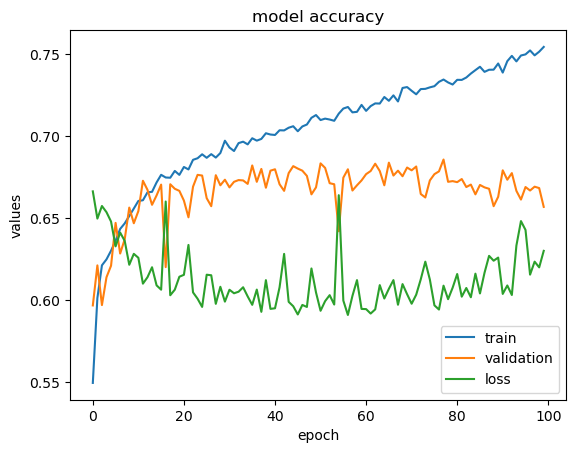

In [169]:

plt.plot(historyf.history['accuracy'])
plt.plot(historyf.history['val_accuracy'])
#plt.plot(historyf.history['val_f1_m'], linestyle='dotted')
plt.plot(historyf.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('values')
plt.xlabel('epoch')
plt.legend(['train', 'validation','loss'], loc='lower right')
plt.show()

In [186]:
#print('max val_accuracy :' + str(max(historyf.history['val_accuracy'])) + '; ' + 'min val_loss : ' + str(min(historyf.history['val_loss'])) )


print('max val_accuracy :' + str(max(historyf.history['val_accuracy'])) + ' : ' + 'max f1-score :' + str(max(historyf.history['val_f1_m'])) + ' : '+ 'max precision :' + str(max(historyf.history['val_precision_m'])) + ' : ' + 'max recall :' + str(max(historyf.history['val_recall_m']))  + ' : ' + 'min val_loss : ' + str(min(historyf.history['val_loss'])) )
      

max val_accuracy :0.6888416409492493 : max f1-score :0.7121114134788513 : max precision :0.7527369260787964 : max recall :0.9982690811157227 : min val_loss : 0.5875348448753357


In [18]:
historyf.history['val_accuracy']

[0.7476052641868591,
 0.7576297521591187,
 0.7885943651199341,
 0.7794609069824219,
 0.7190911173820496,
 0.7894853949546814,
 0.7972822189331055,
 0.7687680721282959,
 0.8019603490829468,
 0.7714412808418274,
 0.8108710050582886,
 0.8124303817749023,
 0.8182223439216614,
 0.8115392923355103,
 0.8191133737564087,
 0.8200044631958008,
 0.8099799752235413,
 0.8251280784606934,
 0.8157718777656555,
 0.7848073244094849,
 0.8010692596435547,
 0.8298062086105347,
 0.8278012871742249,
 0.8226776719093323,
 0.8351525664329529,
 0.8135442137718201,
 0.8298062086105347,
 0.8269101977348328,
 0.8246825337409973,
 0.8322566151618958,
 0.8295834064483643,
 0.8231232166290283,
 0.8298062086105347,
 0.8302517533302307,
 0.8367119431495667,
 0.8197816610336304,
 0.8175539970397949,
 0.8231232166290283,
 0.8315883278846741,
 0.8102027177810669,
 0.824237048625946,
 0.8313655853271484,
 0.8322566151618958,
 0.8304744958877563,
 0.8135442137718201,
 0.8398306965827942,
 0.8088661432266235,
 0.83270215988

In [3]:
predictOnTest = model.predict(input_test[0])
predictOnTest

NameError: name 'modelBest' is not defined

In [123]:
output_test1

array([1, 1, 1, ..., 0, 1, 1])

In [180]:
classifiedArrayPredict = myClassify(predictOnTest, 0.5)
np.array(classifiedArrayPredict)

array([1, 1, 1, ..., 0, 1, 1])

In [133]:

comparePredictOkNokWithSeq(classifiedArrayPredict, output_test1, sequence_test1)

fração de acertos = 
0.8444266238973537


['NOK : ATGCATATAATTTTTCTAGCTGCCTTCAAATAATTGTAGCTCATAACGTTTTGGCAATTTCCTGAGTCTTTACTCGATAGCTTTCAGAATATTTCTATATAGGAAGTTCTGGCTGAAACGTTTTTCCTTATCAGTTAGAGAACGGTGACCATCTCTTGAAAGCGAACAAAAAAACGTGAGGCTAAGGAAGCTATTTAGGAAAATAGACGAAAAAGGAATGGCAAAAGAAGGAATGGCCCTTTCAAAATAGGTATAAGCAGCACAGCTTGATACATGCTAGGGTTGCAGCAGTATAACTGTACTCTCTTTATGAGCGTAGTGAAAAGACGGTGAAATTATAACGGTATGCTCTATGAAGAATAAATGCTGTAGGAAAATTTACGATAATAAAGCCTTTATTGTTGTTGATCAACAAAAGGAGGCTTAAGCAATTGATAAACTTCTGAAAAGAAGAACCCTATTAAAGTTTATATCAAATATAGAAAAAAAAATCTTGAAGT',
 'OK : TTATAGTTGAATGTTTCTTATTCGGTGTTGATAGTAGATGATGACCAAAGCTTTTTTTAACAAACTACCGTTTGAGGTATTCCGTCGGTACGTTAGGACAGGTAAAAGCATCCCTCAAAGAAGCCCCAGGACAAGAAAATCTCTTCTGGTGGGTGGGACTATTGCATCAGCAGTAGTTTTGTACAACTTTAATGACACTTTTCATGATTCTGTAAAGCACACGGCACTGACGACTAAAAGAATCGCTGTCGTCACACAAGCTACCACTCGTTGCTTCTACCATTACAAGAGGGCTCTAAATAAAAGCTATGAGAACAAAAAAGAACGAGAAGTTGCCTTAAATAAATGTCATAAGATGTGTGCCTTAATCACGTTGCATGCGCTACGATCGAATGGTGGGATATATATCAAATTAGGCCAGCACATTGGGGCCATGACCTACCTGTTGCCTAAAGAATGGACGGATACAATGATACCGTTGC

In [334]:
countOutputTrues(output_test1)

1895/3741 = 0.5065490510558674


In [190]:
calcPrecisionAndRecall(classifiedArrayPredict, output_test1)

precision = 1576 / 1576+265 = 0.8560564910374796
recall = 1576 / 1576+319 = 0.8316622691292876


In [ ]:
# model.layers[0].get_weights()[0][0]